In [ ]:
# Install TensorFlow and related libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.17.1


Upload the Images

In [ ]:
from google.colab import files

# Upload the content (dog) image and style (pattern) image
uploaded = files.upload()


Saving dog.jpg to dog.jpg
Saving pattern.jpg to pattern.jpg


Load and Preprocess Images

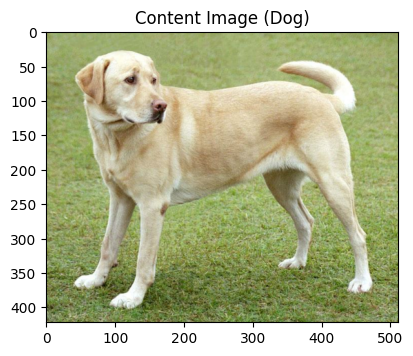

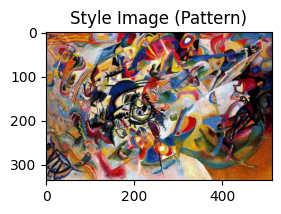

In [ ]:
# Function to load and preprocess an image
def load_img(path_to_img):
    max_dim = 512  # Resize image to this dimension
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize image
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

# Function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# Provide file names of the uploaded images
content_path = "dog.jpg"  # Replace with your dog's file name
style_path = "pattern.jpg"  # Replace with your pattern's file name

# Load and display images
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
imshow(content_image, "Content Image (Dog)")

plt.subplot(1, 2, 2)
imshow(style_image, "Style Image (Pattern)")


Use Pretrained VGG19 Model

In [ ]:
# Load VGG19 model pre-trained on ImageNet
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Define layers to extract style and content representations
content_layers = ['block5_conv2']  # For content
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1',
                'block4_conv1', 'block5_conv1']  # For style

# Number of style layers
num_style_layers = len(style_layers)

# Function to load VGG model with required layers
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    return tf.keras.Model([vgg.input], outputs)

# Extractor model
extractor = vgg_layers(style_layers + content_layers)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Define Style and Content Loss

In [ ]:
# Content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute Gram matrix (captures style information)
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.cast(tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2], tf.float32)
    return result / num_locations

# Style loss
def style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))


tep 7: Define the Style-Content Model

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

# Instantiate the model
extractor = StyleContentModel(style_layers, content_layers)


Step 8: Optimize the Stylized Image

In [ ]:
# Extract style and content targets
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Initialize the input image as a trainable variable
image = tf.Variable(content_image)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

# Weights for losses
style_weight = 1e-2
content_weight = 1e4

# Define Gram Matrix function to handle tensor shapes
def gram_matrix(input_tensor):
    """Calculate Gram Matrix for style representation."""
    # Ensure the input tensor has a batch dimension
    if len(input_tensor.shape) == 3:
        input_tensor = tf.expand_dims(input_tensor, axis=0)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    num_locations = tf.cast(tf.shape(input_tensor)[1] * tf.shape(input_tensor)[2], tf.float32)
    return result / num_locations

# Define loss functions
def style_loss(base_style, target_style):
    """Compute style loss using Gram Matrices."""
    return tf.reduce_mean(tf.square(base_style - target_style))

def content_loss(base_content, target_content):
    """Compute content loss."""
    return tf.reduce_mean(tf.square(base_content - target_content))

# Train step function
@tf.function
def train_step(image):
    """Performs one training step for style transfer."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)

        # Compute content loss
        loss = content_weight * content_loss(outputs['content']['block5_conv2'], content_targets['block5_conv2'])

        # Compute style loss
        style_losses = [style_loss(outputs['style'][name], style_targets[name]) for name in style_targets.keys()]
        loss += style_weight * tf.add_n(style_losses)

    # Compute gradients and update the image
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])

    # Clip the pixel values to ensure they stay in [0, 1] range
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

# Run optimization
epochs = 10
steps_per_epoch = 100

for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {n+1} complete")


Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
Epoch 10 complete


Step 9: Display the Final Stylized Image


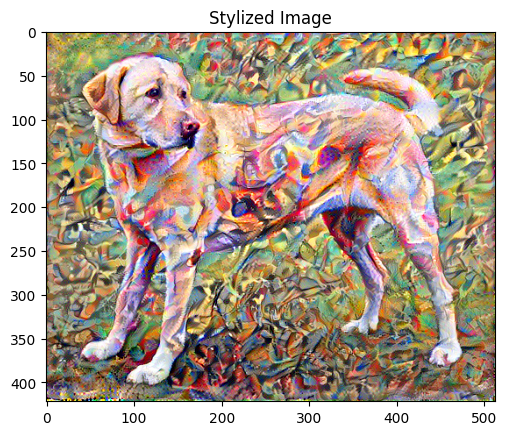

In [ ]:
# Display the output image
imshow(image, "Stylized Image")


Download output Image

In [ ]:
from google.colab import files

# Save and download the stylized image
tf.keras.utils.save_img("stylized_image.png", image[0])
files.download("stylized_image.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>